# Task #1 WORD 2 VEC EMBEDDINGS
Perform sentiment analysis on the Amazon mobile reviews from the `/content/Amazon_Unlocked_Mobile.csv` dataset by:
1. Tokenizing the cleaned reviews.
2. Training a Word2Vec model on the tokenized reviews.
3. Generating review embeddings by averaging the word vectors.
4. Preparing sentiment labels from the 'Rating' column (e.g., ratings 4 and 5 as positive, 1 and 2 and 3 as negative).
5. Splitting the embeddings and labels into training and testing sets.
6. Training a machine learning classifier on the generated embeddings and sentiment labels.
7. Evaluating the classifier's performance using relevant metrics.

In [ ]:
!pip install --upgrade gensim

In [ ]:
!pip install tensorflow

In [ ]:
!pip install transformers

In [9]:
import pandas as pd
from gensim.models import Word2Vec


In [10]:
df=pd.read_csv('/content/Amazon_Unlocked_Mobile.csv', engine='python', on_bad_lines='warn')
df.head()

/tmp/ipython-input-2261561414.py:1: ParserWarning: Skipping line 72666: unexpected end of data

  df=pd.read_csv('/content/Amazon_Unlocked_Mobile.csv', engine='python', on_bad_lines='warn')


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [11]:
reviews_series = df['Reviews']
print("Shape of 'Reviews' before dropping duplicates:", reviews_series.shape)

reviews_unique = reviews_series.drop_duplicates()
print("Shape of 'Reviews' after dropping duplicates:", reviews_unique.shape)

Shape of 'Reviews' before dropping duplicates: (72664,)
Shape of 'Reviews' after dropping duplicates: (19991,)


Here's an explanation of the regular expression used to clean the reviews:

1.  **`https?://\S+`**: Matches URLs starting with `http://` or `https://`.
2.  **`www\.\S+`**: Matches URLs starting with `www.`.
3.  **`[@#]\S+`**: Matches mentions (e.g., `@username`) and hashtags (e.g., `#hashtag`).
4.  **`\d{1,2}:\d{2}(?::\d{2})?(?:\s*[apAP][mM])?`**: Matches time formats like `HH:MM`, `HH:MM:SS`, and `HH:MM AM/PM`.

In [12]:
import re

# Define a regex pattern to match links, mentions, hashtags, and time formats
pattern = r'https?://\S+|www\.\S+|[@#]\S+|\d{1,2}:\d{2}(?::\d{2})?(?:\s*[apAP][mM])?'

# Apply the regex replacement to the unique reviews
reviews_cleaned = reviews_unique.astype(str).str.replace(pattern, '', regex=True)

print("Original first 5 unique reviews (after dropping duplicates):")
print(reviews_unique.head())
print("\nFirst 5 cleaned reviews:")
print(reviews_cleaned.head())

Original first 5 unique reviews (after dropping duplicates):
0    I feel so LUCKY to have found this used (phone...
1    nice phone, nice up grade from my pantach revu...
2                                         Very pleased
3    It works good but it goes slow sometimes but i...
4    Great phone to replace my lost phone. The only...
Name: Reviews, dtype: object

First 5 cleaned reviews:
0    I feel so LUCKY to have found this used (phone...
1    nice phone, nice up grade from my pantach revu...
2                                         Very pleased
3    It works good but it goes slow sometimes but i...
4    Great phone to replace my lost phone. The only...
Name: Reviews, dtype: object


In [13]:
reviews_cleaned_df = pd.DataFrame(reviews_cleaned)
reviews_cleaned_df.columns = ['Cleaned Reviews']

print("Shape of 'reviews_cleaned_df':", reviews_cleaned_df.shape)
print("\nFirst 5 rows of 'reviews_cleaned_df':")
display(reviews_cleaned_df.head())

Shape of 'reviews_cleaned_df': (19991, 1)

First 5 rows of 'reviews_cleaned_df':


,Cleaned Reviews
0,I feel so LUCKY to have found this used (phone...
1,"nice phone, nice up grade from my pantach revu..."
2,Very pleased
3,It works good but it goes slow sometimes but i...
4,Great phone to replace my lost phone. The only...


## Train Word2Vec Model

### Subtask:
Train the Word2Vec model using the `tokenized_reviews`. This will create vector representations for individual words.


In [14]:
from gensim.models import Word2Vec
tokenized_reviews = reviews_cleaned.apply(lambda x: x.split())
print("First 5 tokenized reviews:")
print(tokenized_reviews.head())

# Initialize and train the Word2Vec model
model = Word2Vec(sentences=tokenized_reviews, vector_size=50, window=3, min_count=1, sg=0)
print("Word2Vec model trained successfully.")
print(f"Model vocabulary size: {len(model.wv.index_to_key)}")

First 5 tokenized reviews:
0    [I, feel, so, LUCKY, to, have, found, this, us...
1    [nice, phone,, nice, up, grade, from, my, pant...
2                                      [Very, pleased]
3    [It, works, good, but, it, goes, slow, sometim...
4    [Great, phone, to, replace, my, lost, phone., ...
Name: Reviews, dtype: object
Word2Vec model trained successfully.
Model vocabulary size: 39979


## Generate Review Embeddings

### Subtask:
Create a function to average the word vectors for each review. This will transform each review into a fixed-size vector, suitable for a classifier.


**Reasoning**:
The subtask requires generating review embeddings by applying the previously defined `get_sentence_embedding` function to each cleaned review and then converting the results into a NumPy array.



In [15]:
import numpy as np
def get_sentence_embedding(sentence, model):
    words = sentence.lower().split()
    word_vectors = []
    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

In [16]:
review_embeddings = reviews_cleaned.apply(lambda x: get_sentence_embedding(x, model))
review_embeddings_array = np.array(review_embeddings.tolist())

print("Shape of review_embeddings_array:", review_embeddings_array.shape)

Shape of review_embeddings_array: (19991, 50)


## Prepare Sentiment Labels

### Subtask:
Extract sentiment labels from the 'Rating' column of the original DataFrame. For example, ratings 4 and 5 can be positive, 1 and 2 and 3 as negative.


In [17]:
unique_review_ratings = df.loc[reviews_unique.index, 'Rating']

def map_rating_to_sentiment(rating):
    if rating in [4, 5]:
        return 1  # Positive
    elif rating in [1, 2, 3]:
        return 0 # Negative


sentiment_labels = unique_review_ratings.apply(map_rating_to_sentiment)

# Drop any rows where sentiment_labels might be None due to invalid ratings (if any)
sentiment_labels = sentiment_labels.dropna()

print("Sentiment Label Distribution:")
print(sentiment_labels.value_counts())
print(f"\nShape of sentiment_labels: {sentiment_labels.shape}")

Sentiment Label Distribution:
Rating
1    12865
0     7126
Name: count, dtype: int64

Shape of sentiment_labels: (19991,)


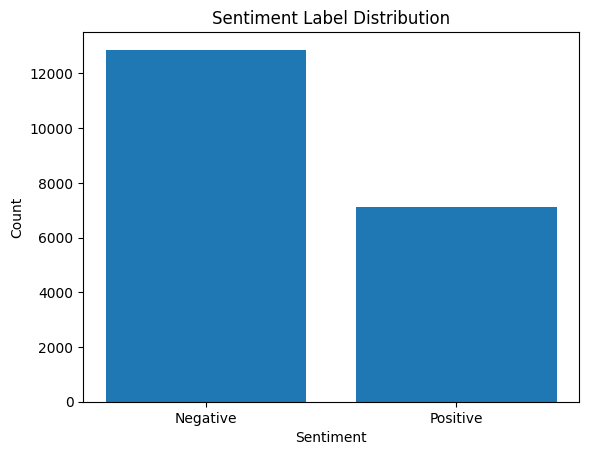

In [18]:
import matplotlib.pyplot as plt
plt.bar(['Negative', 'Positive'], sentiment_labels.value_counts())
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Label Distribution')
plt.show()

## Split Data

### Subtask:
Split the generated review embeddings and corresponding sentiment labels into training and testing sets.


**Reasoning**:
To split the data into training and testing sets as per the instructions, I need to import the `train_test_split` function from `sklearn.model_selection`.



In [19]:
from sklearn.model_selection import train_test_split

# Split the embeddings and sentiment labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    review_embeddings_array,
    sentiment_labels,
    test_size=0.2,
    random_state=42
)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (15992, 50)
Shape of X_test: (3999, 50)
Shape of y_train: (15992,)
Shape of y_test: (3999,)


## Train Sentiment Classifier

### Subtask:
Train a machine learning classifier (e.g., Random Forest  or a simple Neural Network) using the review embeddings as features and the sentiment labels as targets.


**Reasoning**:
To train a machine learning classifier as per the subtask instructions, I will import the `RandomForestClassifier` class, instantiate it with a suitable solver and max_iter, and then train the model using the `X_train` and `y_train` data.



In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Instantiate the RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Train the classifier
model.fit(X_train, y_train)

print("Random Forest Classifier trained successfully.")

Random Forest Classifier trained successfully.


In [21]:
y_preds=model.predict(X_test)
print(f"Model score on testing data:",accuracy_score(y_test, y_preds))
print(classification_report(y_test, y_preds))

Model score on testing data: 0.8407101775443862
              precision    recall  f1-score   support

           0       0.79      0.73      0.76      1387
           1       0.86      0.90      0.88      2612

    accuracy                           0.84      3999
   macro avg       0.83      0.82      0.82      3999
weighted avg       0.84      0.84      0.84      3999



# Task #2 GLOVE EMBEDDINGS
Generate review embeddings for the cleaned reviews using the `get_sentence_embedding_glove` function and the `glove_model`.

## Generate Review Embeddings (GloVe)

### Subtask:
Apply the `get_sentence_embedding_glove` function to each cleaned review, using the loaded `glove_model`, to create GloVe-based review embeddings.


**Reasoning**:
To generate GloVe-based review embeddings, I will apply the `get_sentence_embedding_glove` function to each cleaned review, convert the resulting Series to a NumPy array, and then print its shape to verify the dimensions.



In [22]:
import gensim.downloader as api
# Use pre-trained embeddings (GloVe)
print("\n--- Using Pre-trained Embeddings (GloVe) ---")
glove_model = api.load("glove-wiki-gigaword-50")

# Define a function to get sentence embedding using GloVe
def get_sentence_embedding_glove(sentence, model):
    words = sentence.lower().split()
    word_vectors = []
    for word in words:
        if word in model:
            word_vectors.append(model[word])
    if len(word_vectors) == 0:
        return np.zeros(model['data'].shape[0])
    return np.mean(word_vectors, axis=0)




--- Using Pre-trained Embeddings (GloVe) ---
[==================================================] 100.0% 66.0/66.0MB downloaded


In [23]:
review_embeddings_glove = reviews_cleaned.apply(lambda x: get_sentence_embedding_glove(x, glove_model))
review_embeddings_glove_array = np.array(review_embeddings_glove.tolist())

print("Shape of review_embeddings_glove_array:", review_embeddings_glove_array.shape)

Shape of review_embeddings_glove_array: (19991, 50)


## Split Data (GloVe)

### Subtask:
Split the generated GloVe review embeddings and the existing sentiment labels into training and testing sets.


**Reasoning**:
To split the GloVe embeddings and sentiment labels, I will use the `train_test_split` function with the specified parameters and then print the shapes of the resulting datasets for verification.



In [24]:
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(
    review_embeddings_glove_array,
    sentiment_labels,
    test_size=0.2,
    random_state=42
)

print(f"Shape of X_train_glove: {X_train_glove.shape}")
print(f"Shape of X_test_glove: {X_test_glove.shape}")
print(f"Shape of y_train_glove: {y_train_glove.shape}")
print(f"Shape of y_test_glove: {y_test_glove.shape}")

Shape of X_train_glove: (15992, 50)
Shape of X_test_glove: (3999, 50)
Shape of y_train_glove: (15992,)
Shape of y_test_glove: (3999,)


## Train Sentiment Classifier (GloVe)

### Subtask:
Train a machine learning classifier using the GloVe review embeddings as features and the sentiment labels as targets.

**Reasoning**:
To train a machine learning classifier with the GloVe embeddings, I will use the RandomForestClassifier. I need to instantiate and train the model using the GloVe training data (`X_train_glove`, `y_train_glove`).



In [25]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate the RandomForestClassifier for GloVe embeddings
glove_model_classifier = RandomForestClassifier(random_state=42)

# Train the classifier using GloVe training data
glove_model_classifier.fit(X_train_glove, y_train_glove)

print("Random Forest Classifier trained successfully with GloVe embeddings.")

Random Forest Classifier trained successfully with GloVe embeddings.


**Reasoning**:
After training the classifier with GloVe embeddings, the next step is to evaluate its performance on the test set (`X_test_glove`, `y_test_glove`) using relevant metrics like accuracy and a classification report.



In [26]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the GloVe test set
y_pred_glove = glove_model_classifier.predict(X_test_glove)

# Evaluate the model's performance
print(f"Model score on GloVe testing data: {accuracy_score(y_test_glove, y_pred_glove):.4f}")
print("\nClassification Report (GloVe embeddings):\n")
print(classification_report(y_test_glove, y_pred_glove))

Model score on GloVe testing data: 0.8055

Classification Report (GloVe embeddings):

              precision    recall  f1-score   support

           0       0.74      0.67      0.71      1387
           1       0.83      0.88      0.85      2612

    accuracy                           0.81      3999
   macro avg       0.79      0.77      0.78      3999
weighted avg       0.80      0.81      0.80      3999



# TASK #3 BERT EMBEDDINGS(TRADITIONAL APPROACH)

In [27]:
pip install transformers

In [28]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

print(f"BERT tokenizer and model '{model_name}' loaded successfully.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT tokenizer and model 'bert-base-uncased' loaded successfully.


In [29]:
sample_text = "This is a sample sentence for BERT tokenization."
tokenized_input = tokenizer(sample_text, return_tensors="pt")

print("Original text:", sample_text)
print("Tokenized input (IDs):", tokenized_input['input_ids'])
print("Tokenized input (tokens):", tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'][0]))

Original text: This is a sample sentence for BERT tokenization.
Tokenized input (IDs): tensor([[  101,  2023,  2003,  1037,  7099,  6251,  2005, 14324, 19204,  3989,
          1012,   102]])
Tokenized input (tokens): ['[CLS]', 'this', 'is', 'a', 'sample', 'sentence', 'for', 'bert', 'token', '##ization', '.', '[SEP]']


In [30]:
def get_bert_embedding(text, tokenizer, model, max_length=128):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=max_length)

    # Move inputs to the same device as the model (e.g., GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {key: val.to(device) for key, val in inputs.items()}
    model.to(device)

    # Get model outputs
    with torch.no_grad():
        outputs = model(**inputs)

    # Use the [CLS] token's embedding as the sentence embedding
    # outputs.last_hidden_state has shape (batch_size, sequence_length, hidden_size)
    # We take the embedding of the first token (CLS token)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return cls_embedding

print("BERT embedding function defined.")

BERT embedding function defined.


## Generate BERT Review Embeddings

### Subtask:
Apply the `get_bert_embedding` function to each cleaned review, using the loaded `bert_model` and `tokenizer`, to create BERT-based review embeddings. Convert the resulting embeddings into a NumPy array.

In [31]:
bert_review_embeddings = reviews_cleaned.apply(lambda x: get_bert_embedding(str(x), tokenizer, bert_model))
bert_review_embeddings_array = np.array(bert_review_embeddings.tolist())

print("Shape of bert_review_embeddings_array:", bert_review_embeddings_array.shape)

Shape of bert_review_embeddings_array: (19991, 768)


In [32]:
# Split the BERT embeddings and sentiment labels into training and testing sets
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    bert_review_embeddings_array,
    sentiment_labels,
    test_size=0.2,
    random_state=42
)

print(f"Shape of X_train_bert: {X_train_bert.shape}")
print(f"Shape of X_test_bert: {X_test_bert.shape}")
print(f"Shape of y_train_bert: {y_train_bert.shape}")
print(f"Shape of y_test_bert: {y_test_bert.shape}")

Shape of X_train_bert: (15992, 768)
Shape of X_test_bert: (3999, 768)
Shape of y_train_bert: (15992,)
Shape of y_test_bert: (3999,)


## Train Sentiment Classifier (BERT)

### Subtask:
Train a machine learning classifier using the BERT review embeddings as features and the sentiment labels as targets.

In [33]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate the RandomForestClassifier for BERT embeddings
bert_model_classifier = RandomForestClassifier(random_state=42)

# Train the classifier using BERT training data
bert_model_classifier.fit(X_train_bert, y_train_bert)

print("Random Forest Classifier trained successfully with BERT embeddings.")

Random Forest Classifier trained successfully with BERT embeddings.


**Reasoning**:
After training the classifier with BERT embeddings, the next step is to evaluate its performance on the test set (`X_test_bert`, `y_test_bert`) using relevant metrics like accuracy and a classification report.

In [34]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the BERT test set
y_pred_bert = bert_model_classifier.predict(X_test_bert)

# Evaluate the model's performance
print(f"Model score on BERT testing data: {accuracy_score(y_test_bert, y_pred_bert):.4f}")
print("\nClassification Report (BERT embeddings):\n")
print(classification_report(y_test_bert, y_pred_bert))

Model score on BERT testing data: 0.8802

Classification Report (BERT embeddings):

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1387
           1       0.89      0.93      0.91      2612

    accuracy                           0.88      3999
   macro avg       0.87      0.86      0.87      3999
weighted avg       0.88      0.88      0.88      3999



# TASK#4 BERT EMBEDDINGS(COLLAB WITH TENSORFLOW)

In [35]:
!pip install --upgrade transformers huggingface_hub

In [36]:
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
import tensorflow as tf # Ensure tensorflow is imported

model_name_distil = 'distilbert-base-uncased'
# Load the tokenizer
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained(model_name_distil)

# Load the TensorFlow model for sequence classification with 2 labels
# Load model with classification head for fine-tuning
try:
    ft_model = TFDistilBertForSequenceClassification.from_pretrained(model_name_distil, num_labels=2)
except TypeError as e:
    print("Primary load failed; retrying with from_pt=True, use_safetensors=False")
    print("Error was:", repr(e))
    ft_model = TFDistilBertForSequenceClassification.from_pretrained(
        model_name_distil, num_labels=2, from_pt=True, use_safetensors=False
    )

ft_model

print("DistilBERT tokenizer and TensorFlow model loaded successfully.")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Primary load failed; retrying with from_pt=True, use_safetensors=False
Error was: TypeError("'builtins.safe_open' object is not iterable")


pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

DistilBERT tokenizer and TensorFlow model loaded successfully.


In [ ]:
tokenized_reviews_distilbert = reviews_cleaned.apply(lambda x: distilbert_tokenizer(str(x), truncation=True, padding='max_length', return_tensors='pt'))

print("Tokenization complete. Example keys from the first tokenized review:")
print(tokenized_reviews_distilbert.iloc[0].keys())

In [42]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Convert tokenized_reviews_distilbert Series to a list of dicts
# This ensures train_test_split works correctly with custom objects
X_tokenized = tokenized_reviews_distilbert.tolist()
y_labels = sentiment_labels.values

# Split the tokenized data and sentiment labels into training and testing sets
X_train_distilbert_tok, X_test_distilbert_tok, y_train_distilbert, y_test_distilbert = train_test_split(
    X_tokenized,
    y_labels,
    test_size=0.2,
    random_state=42,
    stratify=y_labels # Stratify to maintain class distribution
)

print(f"Number of training samples: {len(X_train_distilbert_tok)}")
print(f"Number of testing samples: {len(X_test_distilbert_tok)}")

# Function to convert tokenized outputs to TensorFlow Dataset format
def create_tf_dataset(encodings, labels):
    input_ids = tf.constant([x['input_ids'].squeeze().numpy() for x in encodings])
    attention_mask = tf.constant([x['attention_mask'].squeeze().numpy() for x in encodings])
    labels_tf = tf.constant(labels, dtype=tf.int32)

    dataset = tf.data.Dataset.from_tensor_slices(
        ({'input_ids': input_ids, 'attention_mask': attention_mask}, labels_tf)
    )
    return dataset

# Create TensorFlow datasets
train_dataset = create_tf_dataset(X_train_distilbert_tok, y_train_distilbert)
test_dataset = create_tf_dataset(X_test_distilbert_tok, y_test_distilbert)

# Batch the datasets
BATCH_SIZE = 16 # You can adjust this batch size
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("TensorFlow train_dataset and test_dataset created and batched successfully.")

Number of training samples: 15992
Number of testing samples: 3999
TensorFlow train_dataset and test_dataset created and batched successfully.


## Train DistilBERT Classifier (TensorFlow)

### Subtask:
Train the `distilbert_model` using the prepared `train_dataset` and evaluate its performance on the `test_dataset`.

In [44]:
import tensorflow as tf

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

ft_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

print("DistilBERT model compiled successfully.")

# Train the model
epochs = 1 # You can adjust the number of epochs
ft_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset
)

print("DistilBERT model trained successfully.")

# Evaluate the model
loss, accuracy = ft_model.evaluate(test_dataset)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

DistilBERT model compiled successfully.
1000/1000 [==============================] - 482s 458ms/step - loss: 0.1550 - accuracy: 0.9448 - val_loss: 0.2031 - val_accuracy: 0.9257
DistilBERT model trained successfully.
250/250 [==============================] - 33s 130ms/step - loss: 0.2031 - accuracy: 0.9257

Test Loss: 0.2031
Test Accuracy: 0.9257
